#### Binary classification (pretty few features)

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("Data/AIDS_Classification.csv", delimiter=",", skip_header=1)
data = data[~(np.isnan(data)).any(axis=1)]
data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", data.shape[1])
print("Number of datapoints: ", data.shape[0])

def data_split(data, seed):
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=seed)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)
  # y_train = scaler_y.transform(y_train_raw)
  # y_test = scaler_y.transform(y_test_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  return X_train, y_train, X_test, y_test, scaler_y

Number of features:  23
Number of datapoints:  2139


In [9]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

def train_model(model, loops):
    model.to(device=device)
    acc_lst = np.zeros(loops)
    torch.backends.cudnn.deterministic = True
    seeds = range(loops)

    for i, seed in zip(range(loops), seeds):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data, seed)
        torch.manual_seed(seed)
        loss_fn = nn.BCEWithLogitsLoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=150, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        model.eval()
        y_pred = model(X_test) # , dim=1).argmax(dim=1)
        # y_pred = torch.softmax(y_pred)
        y_pred_prob = torch.sigmoid(y_pred)
        y_pred_binary = (y_pred_prob > 0.5).float().cpu().detach()
        acc = accuracy_score(y_test.cpu(), y_pred_binary)
        acc_lst[i] = float(acc)
        print("accuracy:", float(acc))
    return acc_lst

accuracy: 0.8738317757009346
accuracy: 0.8948598130841121
accuracy: 0.9205607476635514
accuracy: 0.9322429906542056
accuracy: 0.9509345794392523


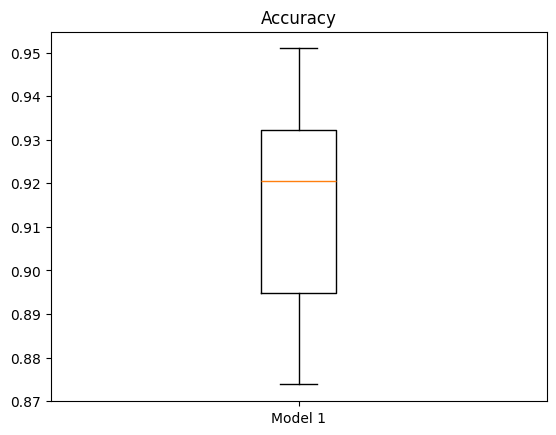

In [10]:
model1 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(10, 1))

acc1 = train_model(model1, 5)
plt.boxplot(acc1, labels=["Model 1"])
plt.title("Accuracy")
plt.show()

accuracy: 0.8714953271028038
accuracy: 0.8948598130841121
accuracy: 0.9065420560747663
accuracy: 0.9158878504672897
accuracy: 0.927570093457944


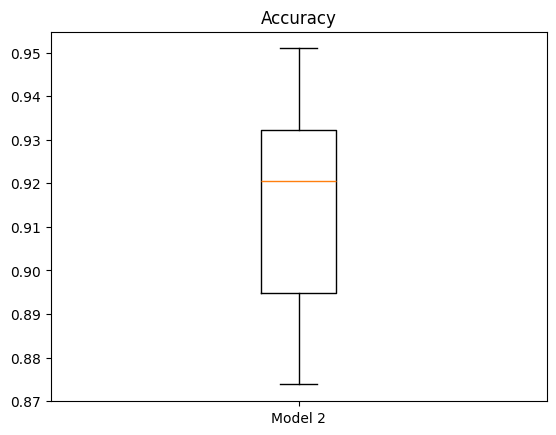

In [11]:
model2 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.BatchNorm1d(100),
    # BatchPitNorm1d(num_features=100, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

model2.to(device=device)

acc2 = train_model(model2, 5)
plt.boxplot(acc1, labels=["Model 2"])
plt.title("Accuracy")
plt.show()

/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q25 = torch.quantile(input=data, q=.25, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:104: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q75 = torch.quantile(input=data, q=.75, dim=0)


accuracy: 0.8621495327102804


/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q25 = torch.quantile(input=data, q=.25, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:104: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q75 = torch.quantile(input=data, q=.75, dim=0)


accuracy: 0.8925233644859814


/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q25 = torch.quantile(input=data, q=.25, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:104: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q75 = torch.quantile(input=data, q=.75, dim=0)


accuracy: 0.9088785046728972


/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q25 = torch.quantile(input=data, q=.25, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:104: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q75 = torch.quantile(input=data, q=.75, dim=0)


accuracy: 0.9392523364485982


/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q25 = torch.quantile(input=data, q=.25, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:104: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q75 = torch.quantile(input=data, q=.75, dim=0)


accuracy: 0.9439252336448598


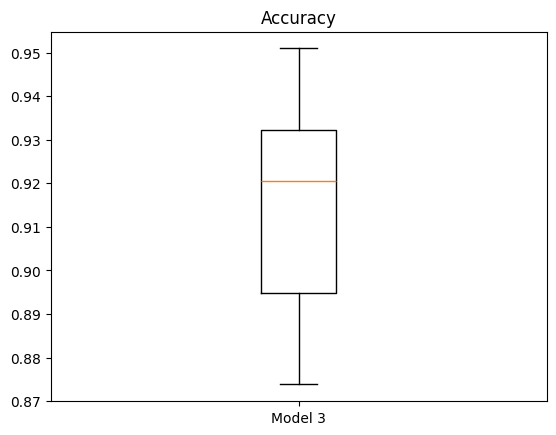

In [12]:
model3 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    BatchPitNorm1d(num_features=100, num_pit_samples=100, take_num_samples_when_full=50, dev=device),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    # BatchPitNorm1d(num_features=10, num_pit_samples=1000, take_num_samples_when_full=50, dev=device),
    nn.Linear(10, 1))
model3.to(device=device)

acc3 = train_model(model3, 5)
plt.boxplot(acc1, labels=["Model 3"])
plt.title("Accuracy")
plt.show()

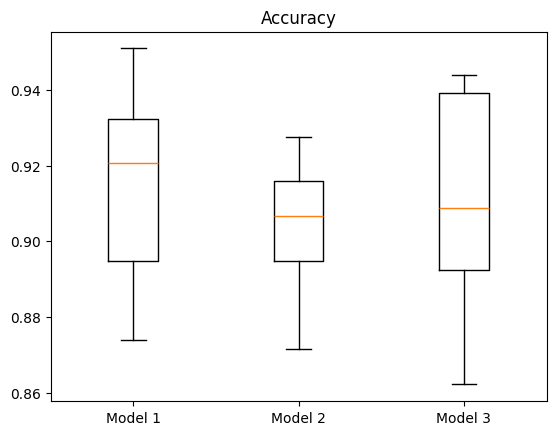

In [13]:
plt.boxplot([acc1, acc2, acc3], labels=["Model 1", "Model 2", "Model 3"])
plt.title("Accuracy")
plt.show()

Model 1: Without any batch layer 

Model 2: With ordinary batch normalization layer.

Model 3: With batch pit normalization layer.

From these three models, the first model (the one without any batch normalization layer) seems to be the best. It seems to be around $92\%$ which is pretty accurate.